Retrait annuel moyen : 15.60 mètres/an
Médiane du retrait annuel : 13.37 mètres/an
Écart-type du retrait annuel : 8.67 mètres/an
Année 1890 : Retrait de 2.67 mètres/an
Année 1925 : Retrait de 6.22 mètres/an
Année 1935 : Retrait de 27.56 mètres/an
Année 1942 : Retrait de 15.19 mètres/an
Année 1948 : Retrait de 12.93 mètres/an
Année 1992 : Retrait de 13.76 mètres/an
Année 2004 : Retrait de 9.33 mètres/an
Année 2010 : Retrait de 12.97 mètres/an
Année 2016 : Retrait de 28.88 mètres/an
Année 2022 : Retrait de 26.53 mètres/an


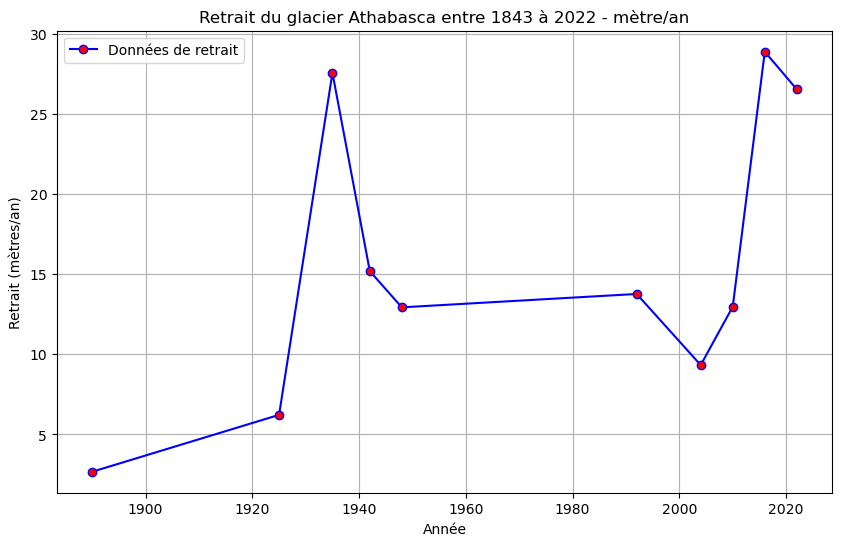

In [34]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger le Shapefile original contenant les points
gdf = gpd.read_file(r"D:\UQTR\Automne 2024\Ouest\retrait_glacier\retrait_points.shp")

# Reprojeter si nécessaire pour travailler dans un système métrique (UTM zone 33N)
gdf = gdf.to_crs(epsg=32611)

# Convertir la colonne 'year' en type numérique
gdf['year'] = pd.to_numeric(gdf['year'], errors='coerce')

# Supprimer les lignes avec des valeurs manquantes ou années hors plage
gdf = gdf.dropna(subset=['year'])
gdf = gdf[(gdf['year'] >= 1843) & (gdf['year'] <= 2024)]

# Trier par année
gdf = gdf.sort_values(by='year').reset_index(drop=True)

# Extraire les années et géométries existantes
years_existing = gdf['year'].values
points_existing = gdf.geometry.values

# Extraire les coordonnées des points existants
x_existing = np.array([point.x for point in points_existing])
y_existing = np.array([point.y for point in points_existing])

# Calculer les distances cumulées en mètres entre les points
distances = np.sqrt(np.diff(x_existing)**2 + np.diff(y_existing)**2)
cumulative_distances = np.cumsum(distances)

# Calculer les retraits annuels (en mètres par an)
years_diff = np.diff(years_existing)
retreat_per_year = np.divide(distances, years_diff)
# Calculer les statistiques de base pour les retraits annuels
mean_retreat = np.mean(retreat_per_year)
median_retreat = np.median(retreat_per_year)
std_dev_retreat = np.std(retreat_per_year)

# Afficher les statistiques
print(f"Retrait annuel moyen : {mean_retreat:.2f} mètres/an")
print(f"Médiane du retrait annuel : {median_retreat:.2f} mètres/an")
print(f"Écart-type du retrait annuel : {std_dev_retreat:.2f} mètres/an")

# Afficher les statistiques de retrait par année
for year, retreat in zip(years_existing[1:], retreat_per_year):
    print(f"Année {year} : Retrait de {retreat:.2f} mètres/an")
# Créer un graphique du retrait par mètre/an
plt.figure(figsize=(10, 6))
plt.plot(years_existing[1:], retreat_per_year, marker='o', linestyle='-', color='blue', markerfacecolor='red', label='Données de retrait')
plt.legend()
plt.title('Retrait du glacier Athabasca entre 1843 à 2022 - mètre/an')
plt.xlabel('Année')
plt.ylabel('Retrait (mètres/an)')
plt.grid(True)

# Afficher le graphique
plt.show()



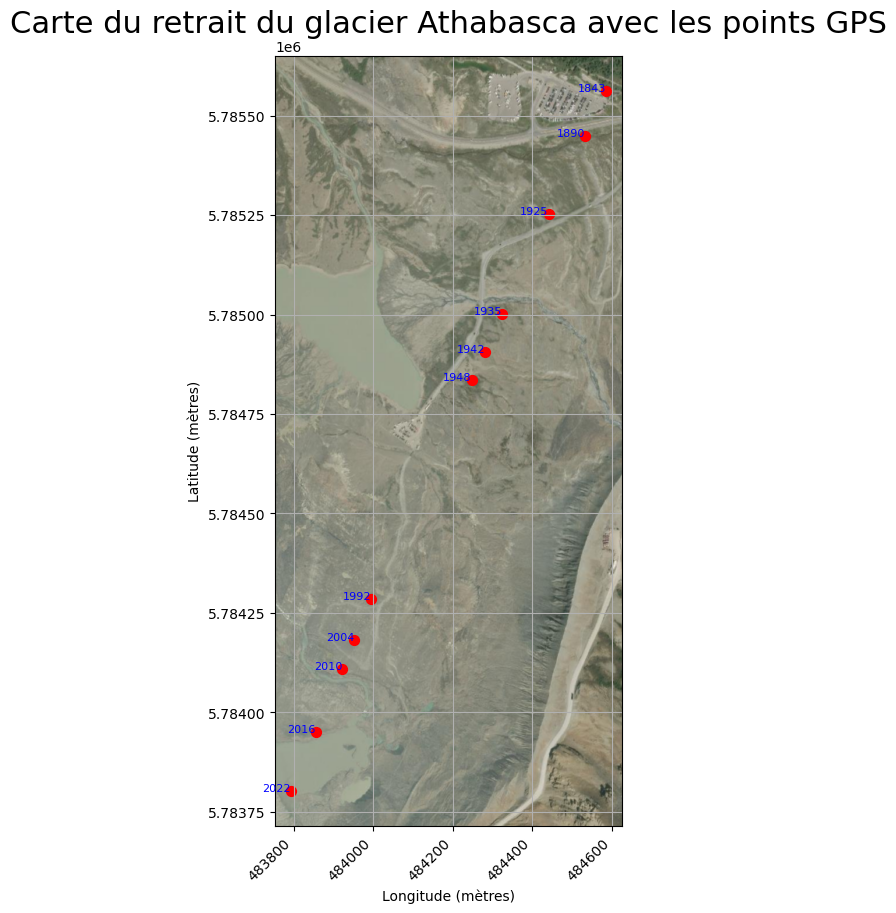

In [52]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx  # Import contextily pour le fond de carte

# Charger le Shapefile original contenant les points
gdf = gpd.read_file(r"D:\UQTR\Automne 2024\Ouest\retrait_glacier\retrait_points.shp")

# Reprojeter si nécessaire pour travailler dans un système métrique (UTM zone 33N)
gdf = gdf.to_crs(epsg=32611)

# Convertir la colonne 'year' en type numérique
gdf['year'] = pd.to_numeric(gdf['year'], errors='coerce')

# Supprimer les lignes avec des valeurs manquantes ou années hors plage
gdf = gdf.dropna(subset=['year'])
gdf = gdf[(gdf['year'] >= 1843) & (gdf['year'] <= 2024)]

# Trier par année
gdf = gdf.sort_values(by='year').reset_index(drop=True)

# Extraire les années et géométries existantes
years_existing = gdf['year'].values
points_existing = gdf.geometry.values

# Extraire les coordonnées des points existants
x_existing = np.array([point.x for point in points_existing])
y_existing = np.array([point.y for point in points_existing])

# Calculer les distances cumulées en mètres entre les points
distances = np.sqrt(np.diff(x_existing)**2 + np.diff(y_existing)**2)
cumulative_distances = np.cumsum(distances)

# Calculer les retraits annuels (en mètres par an)
years_diff = np.diff(years_existing)
retreat_per_year = np.divide(distances, years_diff)

# Créer une figure pour la carte
fig, ax = plt.subplots(figsize=(12, 10))  # Augmenter la taille de la figure pour une carte plus grande et moins rectangulaire

# Tracer les points GPS sur la carte
gdf.plot(ax=ax, marker='o', color='red', markersize=50, label='Points de retrait')

# Ajouter des annotations pour chaque point avec l'année correspondante
for x, y, label in zip(x_existing, y_existing, years_existing):
    ax.text(x, y, str(label), fontsize=8, ha='right', color='blue')

# Ajouter un fond de carte satellite avec contextily (ESRI Satellite en fond)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=gdf.crs.to_string(), attribution='')

# Ajuster les limites de la carte pour qu'elle soit plus large
ax.set_adjustable('box', share=True)

# Ajouter des labels et personnaliser la carte
plt.title('Carte du retrait du glacier Athabasca avec les points GPS', fontsize=22)
# Ajouter des ticks de légende pour éviter la superposition
plt.xticks(rotation=45, ha='right')
plt.xlabel('Longitude (mètres)')
plt.ylabel('Latitude (mètres)')
plt.grid(True)

# Afficher la carte avec une haute résolution de 300 dpi
plt.savefig('carte_retrait_glacier.png', dpi=300)
plt.show()
